In [1]:
!pip install split-folders

In [2]:
import tensorflow as tf
tf.random.set_seed(42)
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pathlib
import splitfolders
import shutil
import warnings
import numpy as np
np.random.seed(42)
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Lets look at the number of images per class

In [3]:
no_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no"
yes_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes"

print(len(os.listdir(no_path)))
print(len(os.listdir(yes_path)))

98
155


This shows that the data is imbalanced, lets balance it using data augmentation

## Data Augmentation

In [4]:
# Making temporary directories that will be deleted later
main_dir = 'temp'
os.mkdir(main_dir)
no_dir = os.path.join(main_dir, 'no')
os.mkdir(no_dir)
yes_dir = os.path.join(main_dir, 'yes')
os.mkdir(yes_dir)

In [5]:
# We are creating temporary directories here because we delete these directories later
aug_dir = 'aug_dir'
os.mkdir(aug_dir)

# create a dir within the base dir to store images of the same class
img_dir = os.path.join(aug_dir, 'img_dir')
os.mkdir(img_dir)

# We are only data augmenting the "NO" class
img_class = 'no'

# list all images in that directory
img_list = os.listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/' + img_class)


for fname in img_list:
    # source path to image
    src = os.path.join('/kaggle/input/brain-mri-images-for-brain-tumor-detection/' + img_class, fname)
    # destination path to image
    dst = os.path.join(img_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# point to a dir containing the images and not to the images themselves
path = aug_dir
save_path = '/kaggle/working/temp/' + img_class

# Create a data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest')

batch_size = 1

aug_datagen = datagen.flow_from_directory(path,
                                          save_to_dir=save_path,
                                          save_format='jpg',
                                          target_size=(224,224),
                                          batch_size=batch_size)


# Generate the augmented images and add them to the training folders
    
# total number of images we want to have in each class
num_aug_images_wanted = 250 
# (Note: We may or may not get the intended num of augmented images, so play will the number. I put 250 here to get 150 images)

num_files = len(os.listdir(img_dir))
num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

# run the generator and create our augmented images
for i in range(0,num_batches):
    imgs, labels = next(aug_datagen)
        
# delete temporary directory with the raw image files
shutil.rmtree('aug_dir')

Found 98 images belonging to 1 classes.


In [6]:
# Copying Yes class images in temp directory
origin_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/'
target_path = '/kaggle/working/temp/yes/'

# Fetching the list of all the files
files = os.listdir(origin_path)

# Fetching all the files to directory
for file_name in files:
    shutil.copy(origin_path+file_name, target_path+file_name)
print("Files are copied successfully")

Files are copied successfully


In [7]:
no_path = "/kaggle/working/temp/no"
yes_path = "/kaggle/working/temp/yes"

print(len(os.listdir(no_path)))
print(len(os.listdir(yes_path)))

152
155


#### The data looks balanced enough.

## Splitting dataset into train, test and val

In [8]:
splitfolders.ratio('/kaggle/working/temp', output='Images', seed=42, ratio=(0.7,0.15,0.15))

Copying files: 307 files [00:00, 6279.45 files/s]


In [9]:
# Deleting the temp directory
shutil.rmtree('/kaggle/working/temp/yes')
shutil.rmtree('/kaggle/working/temp/no')

## Preparing the data

In [10]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

train_generator = data_generator.flow_from_directory(
    directory = '/kaggle/working/Images/train',
    class_mode = 'binary',
    seed = 42,
    target_size = (224, 224),
)
valid_generator = data_generator.flow_from_directory(
    directory = '/kaggle/working/Images/val',
    class_mode = 'binary',
    seed = 42,
    target_size = (224, 224),
)
test_generator = data_generator.flow_from_directory(
    directory = '/kaggle/working/Images/test',
    class_mode = 'binary',
    seed = 42,
    target_size = (224, 224),
)

Found 214 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


## VGG16

In [11]:
basemodel_vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224, 3), classes=2)
basemodel_vgg16.trainable = False
model_vgg16 = tf.keras.Sequential([
    basemodel_vgg16,
    tf.keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),    
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),    
    keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(2, activation='softmax')
])

model_vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                20

In [12]:
cb_earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
cb_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='../working/model_vgg16.hdf5', monitor='val_loss', save_best_only=True, mode='auto', verbose=1)

CALLBACKS = [cb_earlystopper, cb_checkpointer]

In [13]:
model_vgg16.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='accuracy')
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=300,
    validation_data=valid_generator,
    callbacks=CALLBACKS
)

Epoch 1/300
7/7 [==============================] - ETA: 0s - loss: 15.2240 - accuracy: 0.4860
Epoch 1: val_loss improved from inf to 0.66160, saving model to ../working/model_vgg16.hdf5
7/7 [==============================] - 13s 586ms/step - loss: 15.2240 - accuracy: 0.4860 - val_loss: 0.6616 - val_accuracy: 0.5111
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 6.8833 - accuracy: 0.6028
Epoch 2: val_loss improved from 0.66160 to 0.64230, saving model to ../working/model_vgg16.hdf5
7/7 [==============================] - 1s 194ms/step - loss: 6.8833 - accuracy: 0.6028 - val_loss: 0.6423 - val_accuracy: 0.6444
Epoch 3/300
7/7 [==============================] - ETA: 0s - loss: 10.2162 - accuracy: 0.6682
Epoch 3: val_loss improved from 0.64230 to 0.63027, saving model to ../working/model_vgg16.hdf5
7/7 [==============================] - 1s 152ms/step - loss: 10.2162 - accuracy: 0.6682 - val_loss: 0.6303 - val_accuracy: 0.5111
Epoch 4/300
7/7 [============================

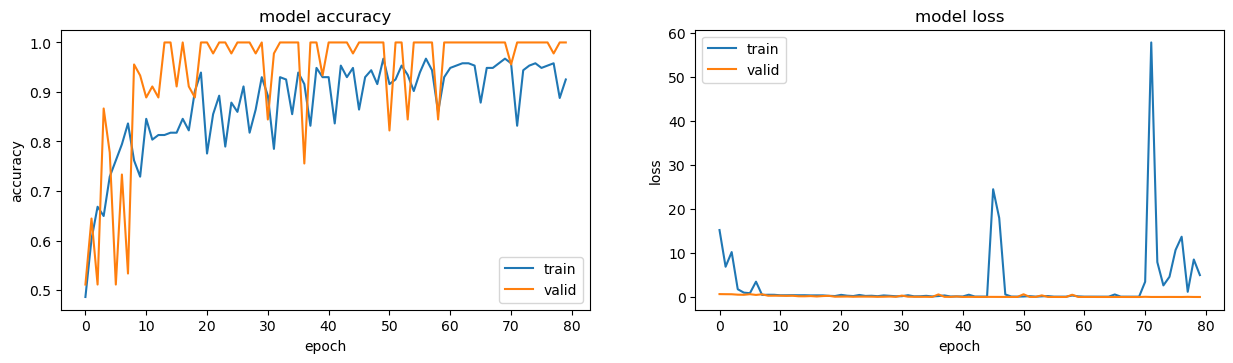

In [14]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history_vgg16.history['accuracy'])  
plt.plot(history_vgg16.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history_vgg16.history['loss'])  
plt.plot(history_vgg16.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [15]:
mymodel = tf.keras.models.load_model('../working/model_vgg16.hdf5')

mymodel.evaluate(test_generator, verbose = 1)

2/2 [==============================] - 2s 1s/step - loss: 0.0649 - accuracy: 0.9792


[0.06493715196847916, 0.9791666865348816]

## VGG19

In [16]:
basemodel_vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224, 3), classes=2)
basemodel_vgg19.trainable = False
model_vgg19 = tf.keras.Sequential([
    basemodel_vgg19,
    tf.keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),    
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),    
    keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(2, activation='softmax')
])

model_vgg19.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                

In [17]:
cb_earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
cb_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='../working/model_vgg19.hdf5', monitor='val_loss', save_best_only=True, mode='auto', verbose=1)

CALLBACKS = [cb_earlystopper, cb_checkpointer]

In [18]:
model_vgg19.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='accuracy')
history_vgg19 = model_vgg19.fit(
    train_generator,
    epochs=300,
    validation_data=valid_generator,
    callbacks=CALLBACKS
)

Epoch 1/300
7/7 [==============================] - ETA: 0s - loss: 23.6717 - accuracy: 0.6215
Epoch 1: val_loss improved from inf to 0.60739, saving model to ../working/model_vgg19.hdf5
7/7 [==============================] - 3s 199ms/step - loss: 23.6717 - accuracy: 0.6215 - val_loss: 0.6074 - val_accuracy: 0.4889
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 143.2774 - accuracy: 0.5888
Epoch 2: val_loss improved from 0.60739 to 0.55187, saving model to ../working/model_vgg19.hdf5
7/7 [==============================] - 1s 146ms/step - loss: 143.2774 - accuracy: 0.5888 - val_loss: 0.5519 - val_accuracy: 0.8222
Epoch 3/300
7/7 [==============================] - ETA: 0s - loss: 111.4110 - accuracy: 0.7056
Epoch 3: val_loss improved from 0.55187 to 0.45768, saving model to ../working/model_vgg19.hdf5
7/7 [==============================] - 1s 192ms/step - loss: 111.4110 - accuracy: 0.7056 - val_loss: 0.4577 - val_accuracy: 0.9333
Epoch 4/300
7/7 [=======================

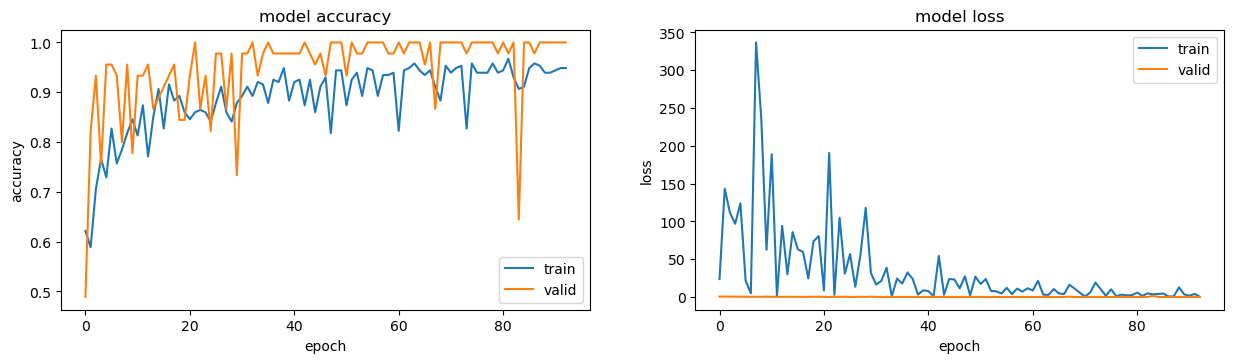

In [19]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history_vgg19.history['accuracy'])  
plt.plot(history_vgg19.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history_vgg19.history['loss'])  
plt.plot(history_vgg19.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [20]:
mymodel = tf.keras.models.load_model('../working/model_vgg19.hdf5')

mymodel.evaluate(test_generator, verbose = 1)

2/2 [==============================] - 0s 45ms/step - loss: 0.4005 - accuracy: 0.9167


[0.40054166316986084, 0.9166666865348816]

## ResNet-50

In [21]:
basemodel_resnet50 = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights="imagenet", input_shape=(224,224, 3), classes=2)
basemodel_resnet50.trainable = False
model_resnet50 = tf.keras.Sequential([
    basemodel_resnet50,
    tf.keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),    
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),    
    keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(2, activation='softmax')
])

model_resnet50.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 256)               524544    
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                

In [22]:
cb_earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
cb_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='../working/model_resnet50.hdf5', monitor='val_loss', save_best_only=True, mode='auto', verbose=1)

CALLBACKS = [cb_earlystopper, cb_checkpointer]

In [23]:
model_resnet50.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='accuracy')
history_resnet50 = model_resnet50.fit(
    train_generator,
    epochs=300,
    validation_data=valid_generator,
    callbacks=CALLBACKS
)

Epoch 1/300
7/7 [==============================] - ETA: 0s - loss: 0.9516 - accuracy: 0.5561
Epoch 1: val_loss improved from inf to 0.57555, saving model to ../working/model_resnet50.hdf5
7/7 [==============================] - 9s 516ms/step - loss: 0.9516 - accuracy: 0.5561 - val_loss: 0.5756 - val_accuracy: 0.6444
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 0.6211 - accuracy: 0.6776
Epoch 2: val_loss improved from 0.57555 to 0.33749, saving model to ../working/model_resnet50.hdf5
7/7 [==============================] - 1s 170ms/step - loss: 0.6211 - accuracy: 0.6776 - val_loss: 0.3375 - val_accuracy: 0.9333
Epoch 3/300
7/7 [==============================] - ETA: 0s - loss: 0.5582 - accuracy: 0.7991
Epoch 3: val_loss did not improve from 0.33749
7/7 [==============================] - 1s 92ms/step - loss: 0.5582 - accuracy: 0.7991 - val_loss: 0.3714 - val_accuracy: 0.8444
Epoch 4/300
7/7 [==============================] - ETA: 0s - loss: 0.4025 - accuracy: 0.8084
E

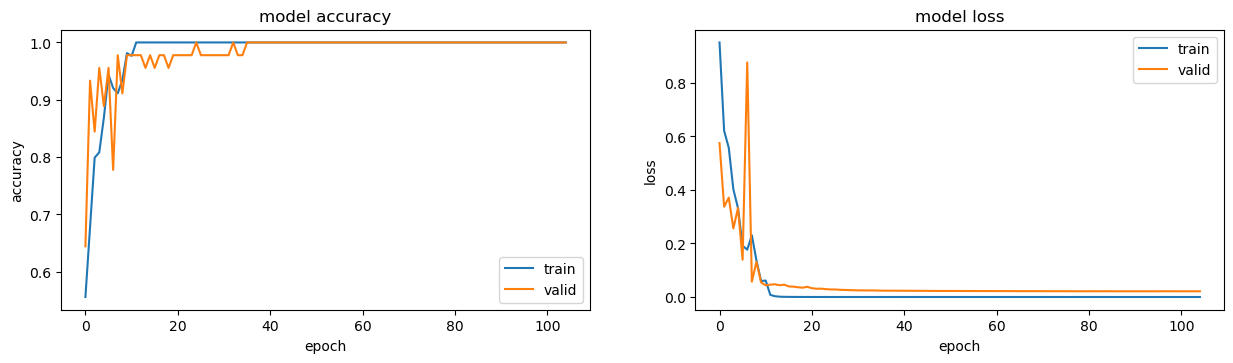

In [24]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history_resnet50.history['accuracy'])  
plt.plot(history_resnet50.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history_resnet50.history['loss'])  
plt.plot(history_resnet50.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [25]:
mymodel = tf.keras.models.load_model('../working/model_resnet50.hdf5')

mymodel.evaluate(test_generator, verbose = 1)

2/2 [==============================] - 2s 601ms/step - loss: 0.5916 - accuracy: 0.9375


[0.5915923714637756, 0.9375]

## Conclusion

VGG16 gives the highest testing accuracy with 97.9%